In [7]:
!pip install PyPokerEngine 
!pip install tensorflow
!pip install matplotlib

In [8]:
# Standard library imports
import os
import random
import sys
import contextlib
from collections import deque

# Third-party library imports for data handling and machine learning
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Input
from tensorflow.keras.utils import to_categorical

# Visualization libraries
import matplotlib.pyplot as plt
from IPython.display import clear_output

# PyPokerEngine imports for game setup and player configuration
from pypokerengine.api.game import setup_config, start_poker
from pypokerengine.players import BasePokerPlayer

# Part i (testing pypokerengine)

In [9]:
class RandomPlayer(BasePokerPlayer):


    def declare_action(self, valid_actions, hole_card, round_state):
        # Choose a random action from the list of valid actions
        action = random.choice(valid_actions)

        # For 'raise' action, choose a valid raise amount within the allowed range
        if action['action'] == 'raise':
            min_raise, max_raise = action['amount']['min'], action['amount']['max']
            # Ensure the raise amount is within the range, considering your stack and the min/max allowed
            #raise_amount = int(max_raise/ 5) 
            raise_amount = random.randint(min_raise, max_raise)
            
            return action['action'], raise_amount
        else:
            # For 'call' or 'fold', the amount is fixed in the valid_actions
            return action['action'], action['amount']


    def receive_game_start_message(self, game_info):
        pass

    def receive_round_start_message(self, round_count, hole_card, seats):
        pass

    def receive_street_start_message(self, street, round_state):
        pass

    def receive_game_update_message(self, action, round_state):
        pass

    def receive_round_result_message(self, winners, hand_info, round_state):
        pass

In [10]:
# Set up the game configuration
config = setup_config(max_round=100, initial_stack=1000, small_blind_amount=10)
config.register_player(name="Player1", algorithm=RandomPlayer())
config.register_player(name="Player2", algorithm=RandomPlayer())

# Start the poker game
game_result = start_poker(config, verbose=1)

Started the round 1
Street "preflop" started. (community card = [])
"Player2" declared "fold:0"
"['Player1']" won the round 1 (stack = {'Player1': 1010, 'Player2': 990})
Started the round 2
Street "preflop" started. (community card = [])
"Player1" declared "call:20"
"Player2" declared "fold:0"
"['Player1']" won the round 2 (stack = {'Player1': 1030, 'Player2': 970})
Started the round 3
Street "preflop" started. (community card = [])
"Player2" declared "raise:320"
"Player1" declared "fold:0"
"['Player2']" won the round 3 (stack = {'Player1': 1010, 'Player2': 990})
Started the round 4
Street "preflop" started. (community card = [])
"Player1" declared "call:20"
"Player2" declared "raise:885"
"Player1" declared "raise:-1"
"['Player2']" won the round 4 (stack = {'Player1': 990, 'Player2': 1010})
Started the round 5
Street "preflop" started. (community card = [])
"Player2" declared "raise:699"
"Player1" declared "raise:-1"
"['Player2']" won the round 5 (stack = {'Player1': 970, 'Player2': 10

In [11]:
class SmartPlayer(BasePokerPlayer):

    def declare_action(self, valid_actions, hole_card, round_state):
        # Process the current game state
        current_street = round_state['street']
        pot_size = round_state['pot']['main']['amount']
        community_cards = round_state['community_card']
        
        # Simple strategy: If we have a pair or high card (A, K, Q, J), we bet, otherwise we fold
        high_cards = ['A', 'K', 'Q', 'J']
        has_high_card = any(card[1] in high_cards for card in hole_card)
        has_pair = hole_card[0][1] == hole_card[1][1]

        if has_high_card or has_pair:
            action = 'raise'
            action_dict = next((item for item in valid_actions if item["action"] == action), None)
            # Check if raise is a valid action, otherwise call
            if action_dict:
                action_amount = random.randint(action_dict["amount"]["min"], action_dict["amount"]["max"])
#                 action_amount = int(action_dict["amount"]["max"] / 5)
            else:
                action = 'call'
                action_dict = next((item for item in valid_actions if item["action"] == action), None)
                action_amount = action_dict["amount"]
        else:
            action = 'fold'
            action_dict = next((item for item in valid_actions if item["action"] == action), None)
            action_amount = action_dict["amount"]

        return action, action_amount

    # The following methods are not modified but are required to be present
    def receive_game_start_message(self, game_info):
        pass

    def receive_round_start_message(self, round_count, hole_card, seats):
        pass

    def receive_street_start_message(self, street, round_state):
        pass

    def receive_game_update_message(self, action, round_state):
        pass

    def receive_round_result_message(self, winners, hand_info, round_state):
        pass

In [12]:
# Set up the game configuration
config = setup_config(max_round=10000, initial_stack=1000, small_blind_amount=10)
config.register_player(name="SmartPlayer1", algorithm=SmartPlayer())
config.register_player(name="SmartPlayer2", algorithm=SmartPlayer())

# Start the poker game
game_result = start_poker(config, verbose=1)

Started the round 1
Street "preflop" started. (community card = [])
"SmartPlayer2" declared "raise:141"
"SmartPlayer1" declared "raise:282"
"SmartPlayer2" declared "raise:494"
"SmartPlayer1" declared "raise:796"
"SmartPlayer2" declared "raise:-1"
"['SmartPlayer1']" won the round 1 (stack = {'SmartPlayer1': 1494, 'SmartPlayer2': 506})
Started the round 2
Street "preflop" started. (community card = [])
"SmartPlayer1" declared "raise:1211"
"SmartPlayer2" declared "fold:0"
"['SmartPlayer1']" won the round 2 (stack = {'SmartPlayer1': 1514, 'SmartPlayer2': 486})
Started the round 3
Street "preflop" started. (community card = [])
"SmartPlayer2" declared "fold:0"
"['SmartPlayer1']" won the round 3 (stack = {'SmartPlayer1': 1524, 'SmartPlayer2': 476})
Started the round 4
Street "preflop" started. (community card = [])
"SmartPlayer1" declared "fold:0"
"['SmartPlayer2']" won the round 4 (stack = {'SmartPlayer1': 1514, 'SmartPlayer2': 486})
Started the round 5
Street "preflop" started. (community 

In [13]:
# Set up the game configuration
config = setup_config(max_round=10000, initial_stack=1000, small_blind_amount=10)
config.register_player(name="SmartPlayer", algorithm=SmartPlayer())
config.register_player(name="RandomPlayer", algorithm=RandomPlayer())

# Start the poker game
game_result = start_poker(config, verbose=1)

Started the round 1
Street "preflop" started. (community card = [])
"RandomPlayer" declared "fold:0"
"['SmartPlayer']" won the round 1 (stack = {'SmartPlayer': 1010, 'RandomPlayer': 990})
Started the round 2
Street "preflop" started. (community card = [])
"SmartPlayer" declared "fold:0"
"['RandomPlayer']" won the round 2 (stack = {'SmartPlayer': 1000, 'RandomPlayer': 1000})
Started the round 3
Street "preflop" started. (community card = [])
"RandomPlayer" declared "fold:0"
"['SmartPlayer']" won the round 3 (stack = {'SmartPlayer': 1010, 'RandomPlayer': 990})
Started the round 4
Street "preflop" started. (community card = [])
"SmartPlayer" declared "raise:798"
"RandomPlayer" declared "fold:0"
"['SmartPlayer']" won the round 4 (stack = {'SmartPlayer': 1030, 'RandomPlayer': 970})
Started the round 5
Street "preflop" started. (community card = [])
"RandomPlayer" declared "fold:0"
"['SmartPlayer']" won the round 5 (stack = {'SmartPlayer': 1040, 'RandomPlayer': 960})
Started the round 6
Stre

# Part II (building deep Q network)

## 1 (initializing network)

In [14]:
def initialize_network(input_shape, action_size):
    # Input layer
    input_layer = Input(shape=input_shape)

    # Shared layers
    x = layers.Dense(128, activation='relu')(input_layer)
    x = layers.Dense(32, activation='relu')(x)

    # Action output
    action_output = layers.Dense(action_size, activation='linear', name='action_output')(x)

    # Bet amount output
    bet_amount_output = layers.Dense(5, activation='softmax', name='bet_amount_output')(x)

    # Build the model
    model = models.Model(inputs=input_layer, outputs=[action_output, bet_amount_output])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss={'action_output': 'mse', 'bet_amount_output': 'categorical_crossentropy'},
                  metrics={'action_output': 'accuracy', 'bet_amount_output': 'accuracy'})

    return model

In [15]:
def load_or_initialize_model(model_path, input_shape, action_size):
    print(model_path)
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}")
        model = keras.models.load_model(model_path)
    else:
        print("Initializing new model")
        model = initialize_network(input_shape, action_size)
    return model

## 2 (encode cards)

In [16]:
# Constants
NUM_SUITS = 4
NUM_RANKS = 13
MAX_COMMUNITY_CARDS = 5
LARGE_NUMBER = 10000
NUM_PLAYERS = 4  # Adjust based on your game setup
BETTING_HISTORY_SIZE = 10  # Last 10 actions, adjust as needed

default_category = 0

def encode_card(card):
    """Encode a card as a one-hot vector for its rank and suit."""
    rank, suit = card[1], card[0]
    rank_index = '23456789TJQKA'.index(rank)
    suit_index = 'SHDC'.index(suit)
    rank_one_hot = np.eye(NUM_RANKS)[rank_index]
    suit_one_hot = np.eye(NUM_SUITS)[suit_index]
    return np.concatenate([rank_one_hot, suit_one_hot])

In [17]:
encode_card(('C', '2'))  # Example usage

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

## 3 (choose action function)

In [18]:
def choose_action(state, model, valid_actions, epsilon):
    # Initialize default values
    best_action = None
    bet_amount_category = 0  # Default to the first category

    if not valid_actions:
        raise ValueError("No valid actions provided.")

    if np.random.rand() <= epsilon:
        # Exploration: Randomly choose a valid action
        best_action = np.random.choice([action['action'] for action in valid_actions])
        # Randomly choose a bet amount category (assuming a fixed number of categories)
        bet_amount_category = np.random.randint(0, 5)  # Adjust '5' to your number of bet amount categories
    else:
        # Exploitation: Predict Q-values for actions and bet amounts
        predictions = model.predict(state.reshape(1, -1))
        q_values = predictions[0][0]  # Assuming the first output corresponds to actions
        bet_amounts = predictions[1][0]  # Assuming the second output corresponds to bet amounts

        # Map valid actions to their indices
        action_indices = {action['action']: idx for idx, action in enumerate(valid_actions)}

        # Ensure there is a best action by selecting the first valid action as default
        if valid_actions:
            best_action = valid_actions[0]['action']

        # Choose the best action based on Q-values, considering only valid actions
        valid_q_values = [q_values[action_indices[action['action']]] for action in valid_actions]
        best_action = valid_actions[np.argmax(valid_q_values)]['action']

        # Choose the bet amount category with the highest probability
        bet_amount_category = np.argmax(bet_amounts)

    if best_action is None:
        raise ValueError("Unable to determine a best action. Check the logic and inputs.")

    return best_action, bet_amount_category

## Reward function

In [19]:
def compute_reward(round_state, action, action_details, is_winner, pot_size_before, pot_size_after, stack_size_before, stack_size_after, hole_cards, community_cards):
    """
    Compute a simplified reward considering the action taken and game outcome without estimating hand strength.
    
    Args:
        round_state (dict): The state of the current round.
        action (str): The action taken by the agent.
        action_details (dict): Additional details about the action, such as the bet amount.
        is_winner (bool): Indicates whether the player won in this round.
        pot_size_before (int): The size of the pot before the action was taken.
        pot_size_after (int): The size of the pot after the action was taken.
        stack_size_before (int): The player's stack size before the action.
        stack_size_after (int): The player's stack size after the action.
        hole_cards (list): List of player's hole cards as string.
        community_cards (list): List of community cards on the table as string.

    Returns:
        reward (float): The computed reward.
    """
    reward = 0

    # Adjust rewards for winning or losing the round
    if is_winner:
        reward += 10  # Reward for winning
    else:
        reward -= 10  # Penalty for losing

    # Consider the action taken
    if action == 'fold':
        reward -= 5  # Discourage folding by default
    elif action == 'raise':
        bet_amount = action_details.get('amount', 0)
        pot_ratio = bet_amount / max(1, pot_size_before)  # Avoid division by zero
        reward += 5 * pot_ratio  # Reward for aggressive play when raising

    # Adjust reward based on changes in stack size, to encourage preservation of chips
    stack_change = stack_size_after - stack_size_before
    reward += stack_change / 100.0  # Small reward/penalty based on stack change

    return reward

## Replay buffer

In [20]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)

    def add(self, state, action, bet_amount_category, reward, next_state, done):
        """Add a new experience to the buffer."""
        # Include bet_amount_category in the stored experience
        self.buffer.append((state, action, bet_amount_category, reward, next_state, done))

    def sample(self, batch_size):
        """Sample a batch of experiences from the buffer."""
        batch = random.sample(self.buffer, min(len(self.buffer), batch_size))
        # Unpack bet_amount_category along with other experience components
        states, actions, bet_amount_categories, rewards, next_states, dones = zip(*batch)
        return states, actions, bet_amount_categories, rewards, next_states, dones

## Replay Function

In [21]:
def replay(replay_buffer, model, target_model, batch_size, gamma):
    """Sample a batch of experiences and use them to update the model with dual outputs (action and bet_amount).
    
    Args:
        replay_buffer (ReplayBuffer): The replay buffer to sample experiences from.
        model (tf.keras.Model): The current model.
        target_model (tf.keras.Model): The target model.
        batch_size (int): The number of experiences to sample from the buffer.
        gamma (float): The discount factor for future rewards.
    """
    # Sample a batch of experiences from the replay buffer
    states, actions, bet_amount_categories, rewards, next_states, dones = replay_buffer.sample(batch_size)

    # Convert lists to numpy arrays for batch processing
    states = np.array(states)
    next_states = np.array(next_states)
    rewards = np.array(rewards)
    dones = np.array(dones)

    # Predict the Q-values for the next states using the target model
    next_q_values_action, next_q_values_bet_amount = target_model.predict(next_states)

    # Compute the Q-value targets for actions
    targets_action = rewards + gamma * np.max(next_q_values_action, axis=1) * (1 - dones)

    # Predict the Q-values for the current states using the model
    q_values_action, q_values_bet_amount = model.predict(states)

    # Update the Q-values for the actions taken with the computed targets
    for i, action in enumerate(actions):
        q_values_action[i, action] = targets_action[i]
    
    # Replace None with default_category
    bet_amount_categories = np.array([cat if cat is not None else default_category for cat in bet_amount_categories], dtype='int64')

    # Convert bet_amount_categories to one-hot encoding for training the bet amount prediction part of the model
    bet_amount_categories_one_hot = to_categorical(bet_amount_categories, num_classes=q_values_bet_amount.shape[1])

    # Train the model
    model.fit(states, [q_values_action, bet_amount_categories_one_hot], epochs=1, verbose=0)

## Update target network

In [22]:
def update_target_network(main_q_network, target_q_network):
    """Update the target Q-network's weights with the main Q-network's weights.
    
    Args:
        main_q_network (tf.keras.Model): The main Q-network being trained.
        target_q_network (tf.keras.Model): The target Q-network used for stability.
    """
    # Get the weights from the main Q-network
    main_q_weights = main_q_network.get_weights()
    
    # Set the weights in the target Q-network
    target_q_network.set_weights(main_q_weights)

# Integrating into the environment

In [23]:
class DQNPokerAgent:
    def __init__(self, state_size, action_size, model=None, replay_buffer_size=50000, batch_size=32, gamma=0.95, epsilon=1, epsilon_min=0.01, epsilon_decay=0.9995):
        self.state_size = state_size
        self.action_size = action_size
        self.replay_buffer = ReplayBuffer(replay_buffer_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = model
        
        # If a model is provided, use it; otherwise, initialize a new model
        self.q_network = model if model else initialize_network((state_size,), action_size)

        # Initialize the target Q-network
        self.target_q_network = initialize_network((state_size,), action_size)
        self.update_target_network()

    def update_target_network(self):
        """Updates the target Q-network's weights."""
        update_target_network(self.q_network, self.target_q_network)

    def act(self, state, valid_actions):
        """Choose an action and a bet amount category based on the current state."""
        action, bet_amount_category = choose_action(np.reshape(state, [1, self.state_size]), self.q_network, valid_actions, self.epsilon)
        return action, bet_amount_category

    def learn(self):
        """Trains the model using a batch of experiences from the replay buffer."""
        # Sample a batch of experiences from the replay buffer
        states, actions, bet_amount_categories, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # Proceed with the rest of the training process by updating the Q-network and target Q-network
        replay(self.replay_buffer, self.q_network, self.target_q_network, self.batch_size, self.gamma)
        
        # Epsilon decay
        print(self.epsilon)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## Defining a custom poker player

In [24]:
class DQNPokerPlayer(BasePokerPlayer):
    def __init__(self, dqn_agent, name, state_size, training_mode=True):
        super().__init__()
        self.dqn_agent = dqn_agent
        self.name = name
        self.current_state = np.zeros(state_size)
        self.prev_state = np.zeros(state_size)
        self.hole_card = None
        self.last_action = None
        self.action_index = None
        self.bet_amount_category = None
        self.done = False
        self.last_action_details = {'action': None, 'amount': 0}  # Initialize with default values
        
        self.training_mode = training_mode  # New flag to indicate training mode
        self.games_since_last_learn = 0  


    def declare_action(self, valid_actions, hole_card, round_state):
        if self.current_state is None:
            self.current_state = self._extract_state(round_state, hole_card)
            print("State size:", state.shape)  # Should output (130,)


        action, bet_amount_category = self.dqn_agent.act(self.current_state, valid_actions)
        self.last_action = action
        self.bet_amount_category = bet_amount_category

        action_index = self.map_action_to_index(action, valid_actions)
        self.action_index = action_index

        action_dict = next((item for item in valid_actions if item["action"] == action), None)

        if action == 'raise' and isinstance(action_dict['amount'], dict):
            min_raise = action_dict['amount']['min']
            max_raise = action_dict['amount']['max']
            fraction = (self.bet_amount_category + 1) / 5
            amount = int(min_raise + fraction * (max_raise - min_raise))
        else:
            amount = action_dict['amount'] if action_dict else 0
#         print('## amount', amount)

        self.last_action_details = {'action': action, 'amount': amount}  # Update action details
#         print(f"declare_action - last_action_details: {self.last_action_details}")

        return action, amount

    
    
    
    def receive_game_start_message(self, game_info):
        for seat in game_info['seats']:
            if seat['name'] == self.name:
                self.uuid = seat['uuid']
                break
                
    def receive_round_start_message(self, round_count, hole_card, seats):
        self.hole_card = hole_card  # Update hole_card at the start of each round

        
    def receive_game_update_message(self, action, round_state):
        self.prev_state = self.current_state  # Store the current state as the previous state
        
        if self.current_state is None:
                print('None detected in receive_game_update_message', self.current_state)
        
        if self.hole_card:  # Ensure hole_card has been set
            self.current_state = self._extract_state(round_state, self.hole_card)
            
        self.pot_size_before = round_state['pot']['main']['amount']
        self.stack_size_before = self._get_stack_size(self.uuid, round_state)
    
    def _get_stack_size(self, player_uuid, round_state):
        # Iterate through the list of players (seats) in the round_state
        for player_info in round_state['seats']:
            # Check if the current player's UUID matches the specified player_uuid
            if player_info['uuid'] == player_uuid:
                # Return the stack size of the matching player
                return player_info['stack']
        # Return None or an appropriate default value if the player is not found
        return None

    

    def receive_round_result_message(self, winners, hand_info, round_state):
        is_winner = any(winner['uuid'] == self.uuid for winner in winners)

        # Use the stored action details directly, ensuring it's not None
        action_details = self.last_action_details if self.last_action_details is not None else {'action': 'default', 'amount': 0}

        # Adjust to handle cards that might already be strings
        hole_cards = [card if isinstance(card, str) else card.to_str() for card in self.hole_card]
        community_cards = [card if isinstance(card, str) else card.to_str() for card in round_state['community_card']]

        pot_size_before = self.pot_size_before
        pot_size_after = round_state['pot']['main']['amount']
        stack_size_before = self.stack_size_before
        stack_size_after = self._get_stack_size(self.uuid, round_state)


        self.done = True

        if self.bet_amount_category is None:
            self.bet_amount_category = 0  # Assuming '0' as default category

        if self.training_mode:
            
            # Compute the reward with additional parameters
            reward = compute_reward(
                round_state,
                self.last_action,
                action_details,
                is_winner,
                pot_size_before,
                pot_size_after,
                stack_size_before,
                stack_size_after,
                hole_cards,
                community_cards,
                  # Number of players
            )
            
            self.dqn_agent.replay_buffer.add(self.prev_state, self.action_index, self.bet_amount_category, reward, self.current_state, self.done)
            self.games_since_last_learn += 1

            if self.games_since_last_learn >= 10:
                self.dqn_agent.learn()
                self.games_since_last_learn = 0

        # Reset for the next round
        self.done = False
        self.prev_state = None
        self.action_index = None
        self.bet_amount_category = None
        self.last_action_details = {'action': None, 'amount': 0}


        
    def _get_stack_size(self, uuid, round_state):
        for player in round_state['seats']:
            if player['uuid'] == uuid:
                return player['stack']
        return None



    def _extract_state(self, round_state, hole_card):
        MAX_COMMUNITY_CARDS = 5
        MAX_PLAYERS = 10  # Define the maximum number of players you expect in any game
        LARGE_NUMBER = 10000  # Normalization factor for large values like stacks and pots

        # Encoding hole and community cards
        hole_cards_encoded = [encode_card(card) for card in hole_card]
        community_cards_encoded = [encode_card(card) for card in round_state['community_card']]

        # Determine the vector size for a single card
        N = len(encode_card(hole_card[0])) if hole_card else 26  # Example fallback size if encode_card size is not standard

        # Flatten encoded cards into single vectors
        hole_cards_vector = np.concatenate(hole_cards_encoded) if hole_cards_encoded else np.zeros(N * 2)
        community_cards_vector = np.concatenate(community_cards_encoded) if community_cards_encoded else np.zeros(N * len(community_cards_encoded))

        # Define a zero vector for padding community cards
        zero_vector = np.zeros(N)
        padded_community_cards = np.concatenate([community_cards_vector] + [zero_vector for _ in range(MAX_COMMUNITY_CARDS - len(community_cards_encoded))])

        # Additional game features
        pot_size = np.array([round_state['pot']['main']['amount'] / LARGE_NUMBER])  # Normalize pot size

        # Encoding player stack sizes and positions
        seats = round_state['seats']
        stack_sizes = [seat['stack'] / LARGE_NUMBER for seat in seats if 'stack' in seat]
        positions = [1 if i == round_state.get('dealer_btn') else 0 for i in range(len(seats))]

        # Optional: Number of active players (can be useful in strategy decision making)
        active_players = [1 if 'folded' not in seat['state'] else 0 for seat in seats]

        # Padding for player-related features if there are fewer players than MAX_PLAYERS
        stack_sizes += [0] * (MAX_PLAYERS - len(stack_sizes))
        positions += [0] * (MAX_PLAYERS - len(positions))
        active_players += [0] * (MAX_PLAYERS - len(active_players))

        # Convert lists to numpy arrays
        stack_sizes = np.array(stack_sizes)
        positions = np.array(positions)
        active_players = np.array(active_players)

        # Concatenate all parts to form the full state vector
        state = np.concatenate([hole_cards_vector, padded_community_cards, pot_size, stack_sizes, positions, active_players])

        return state


    def map_action_to_index(self, action, valid_actions):
        # Convert the action to an index. This implementation depends on how your actions are structured.
        action_dict = {act['action']: idx for idx, act in enumerate(valid_actions)}
        return action_dict.get(action, -1)  # Return -1 or another value for invalid actions
    
    def receive_street_start_message(self, street, round_state):
        pass

## Setup Poker Game

In [25]:
def setup_poker_game(dqn_agent1, initial_stack = 1000):
    state_size = 150
    action_size = 3
    
    # Randomly decide the number of players (between 2 and 10 for example)
    num_players = random.randint(2, 5)
    
    config = setup_config(max_round=100, initial_stack = initial_stack, small_blind_amount=10)
    
    # Register the main training player
    dqn_player1 = DQNPokerPlayer(dqn_agent1, "DQN_Player_Train", state_size, training_mode=True)
    config.register_player(name="DQN_Player_Train", algorithm=dqn_player1)
    
    # Optionally, load or initialize additional models if needed
    model_path = './my_dqn_model.keras'
    
    # Register other players, potentially older versions or different strategies
    for i in range(1, num_players):
        dqn_model = load_or_initialize_model(model_path, state_size, action_size)
        dqn_agent = DQNPokerAgent(state_size, action_size, model=dqn_model, epsilon=0.0)
        dqn_player = DQNPokerPlayer(dqn_agent, f"DQN_Player_Old_{i}", state_size, training_mode=False)
        config.register_player(name=f"DQN_Player_Old_{i}", algorithm=dqn_player)

    # # Optionally, add other types of players
    # config.register_player(name="Random_Player", algorithm=RandomPlayer())
    # config.register_player(name="SmartPlayer", algorithm=SmartPlayer())

    return config

# Training the model

In [26]:

#This is to suppress stdouts of tensorflow which I can't somhow suppress
@contextlib.contextmanager
def suppress_stdout():
    original_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    try:
        yield
    finally:
        sys.stdout.close()
        sys.stdout = original_stdout

Epsilon after episode 45: 0.9940164725309134


<Figure size 640x480 with 0 Axes>

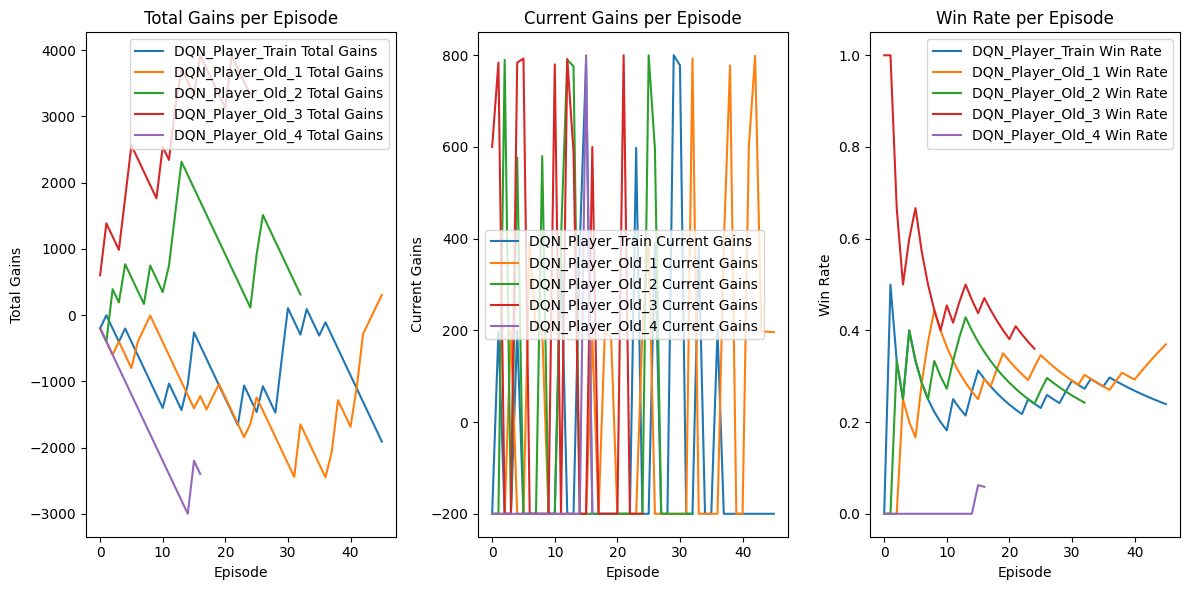

KeyboardInterrupt: 

In [38]:
# Initialize dictionaries to store metrics for each player
total_gains = {}
cumulative_rewards = {}
win_rates = {}
current_gains = {}

# Define model path
model_path = './my_dqn_model.keras'

# Define the input shape and action size for your model
input_shape = (150,)
action_size = 3
state_size = input_shape[0]

# Initialize or load the main model
dqn_model = load_or_initialize_model(model_path, input_shape, action_size)
dqn_agent = DQNPokerAgent(state_size, action_size, model=dqn_model,epsilon = 1)
# Save the current model for the other players
dqn_model.save(model_path)


# Training loop...
for episode in range(100):

    with suppress_stdout():

        #initial_stack = random.randint(1, 10) * 100 #every game will have different initial stacks for now small blind remains 10
        initial_stack = 200

#     if 1==1:
        # Setup and start the poker game with the current model playing against its previous version
        config = setup_poker_game(dqn_agent, initial_stack = initial_stack)
        game_result = start_poker(config, verbose=0)

        # Update metrics based on game results...
        for player in game_result['players']:
            name = player['name']
            stack_change = player['stack'] - initial_stack

            # Initialize player metrics if new
            if name not in total_gains:
                total_gains[name] = [0]
                cumulative_rewards[name] = []
                win_rates[name] = []
                current_gains[name] = []

            # Update player metrics
            total_gains[name].append(total_gains[name][-1] + stack_change)
            current_gains[name].append(stack_change)
            cumulative_rewards[name].append(total_gains[name][-1])
            #win_rate = sum(r > 0 for r in total_gains[name]) / len(total_gains[name])
            win_rate = sum(r > 0 for r in current_gains[name]) / len(current_gains[name])
            win_rates[name].append(win_rate)

    if episode % 5 == 0:
        clear_output(wait=True)
        print(f"Epsilon after episode {episode}: {dqn_agent.epsilon}")

        # Save the current model
        dqn_model.save(model_path)
#         print("Saved the current model.")

        # Clear the current figure to ensure old plots are not shown
        plt.clf()

        # Plot metrics
        plt.figure(figsize=(12, 6))

        # Plot cumulative rewards
        plt.subplot(1, 3, 1)
        for name, rewards in cumulative_rewards.items():
            plt.plot(rewards, label=f'{name} Total Gains')
        plt.xlabel('Episode')
        plt.ylabel('Total Gains')
        plt.title('Total Gains per Episode')
        plt.legend()

        # Plot current gains
        plt.subplot(1, 3, 2)
        for name, gains in current_gains.items():
            plt.plot(gains, label=f'{name} Current Gains')
        plt.xlabel('Episode')
        plt.ylabel('Current Gains')
        plt.title('Current Gains per Episode')
        plt.legend()

        # Plot win rates
        plt.subplot(1, 3, 3)
        for name, rates in win_rates.items():
            plt.plot(rates, label=f'{name} Win Rate')
        plt.xlabel('Episode')
        plt.ylabel('Win Rate')
        plt.title('Win Rate per Episode')
        plt.legend()

        plt.tight_layout()
        plt.show()


In [32]:
for name, rewards in cumulative_rewards.items():
    print(f"{name} Final Total Gains: {rewards[-1]}")

DQN_Player_Train Final Total Gains: 14210
DQN_Player_Old_1 Final Total Gains: 167260
DQN_Player_Old_2 Final Total Gains: -48573
DQN_Player_Old_3 Final Total Gains: -113969
DQN_Player_Old_4 Final Total Gains: -25290
